Criacao da tabela base_engajamento_canais 

In [0]:
%sql
---Identificar se as tabelas subiram corretamente
%sql
SHOW TABLES IN default;


database,tableName,isTemporary
default,agosto,false
default,base_engajamento_canais,false
default,cluster_merchant_history,false
default,communications_base,false
default,conversion_base,false
default,fato_cliente_mes,false
default,kpi_geral_vip_ndc_retencao,false
default,kpi_mes,false
default,kpi_ndc_regiao,false
default,kpi_ndc_regiao_canal,false


In [0]:
#vizualização de uma tabela
spark.table("communications_base").limit(5).display()


nome_campanha,JobID,BatchID,SubscriberKey,provider,tipo_disparo,etapa,data_primeira_acao,data_ultima_acao,value,dt,frente,categoria,flag_regua
CRM_REST_RE0802_20240828_OPTIN-WPP-TESTE-MANUAL-2_WPP_PI_CI_CLGER,323789,4f101774-ea36-4b8a-a4ab-05b19f5894eb,fex351c1-ba3a-y9yc-ad66-9e31x51x0dxb,MKT CLOUD WPP,WHATSAPP,DELIVERED_SUCCESS,2024-08-28T18:33:40.000Z,2024-08-28T18:33:40.000Z,1,2024-08-28,CENTRAL_DE_CRESCIMENTO,CAMPANHA_INTELIGENTE,PONTUAL_BAU
CRM_REST_RE0803_20240828_TESTE-OPTIN-MANUAL-V2_WPP_PI_CLUB_CLNOV,323789,38b92715-3128-4a32-b37c-200210706b8c,ZZcb10ax-816b-y9xf-a9y8-Zee0yee6a53x,MKT CLOUD WPP,WHATSAPP,FAILED,2024-08-28T18:26:47.000Z,2024-08-28T18:26:47.000Z,1,2024-08-28,CENTRAL_DE_CRESCIMENTO,CLUBE_IFOOD,PONTUAL_BAU
CRM_REST_RE0802_20240828_OPTIN-WPP-TESTE-MANUAL-2_WPP_PI_CI_CLGER,323789,193b8869-3d15-4ecc-85ac-7e8369ea6930,1xa5daxZ-1951-y3ce-9Zef-ef60yef6cy5e,MKT CLOUD WPP,WHATSAPP,DELIVERED_SUCCESS,2024-08-28T18:42:25.000Z,2024-08-28T18:42:25.000Z,1,2024-08-28,CENTRAL_DE_CRESCIMENTO,CAMPANHA_INTELIGENTE,PONTUAL_BAU
CRM_REST_RE0802_20240828_OPTIN-WPP-TESTE-MANUAL-2_WPP_PI_CI_CLGER,323789,55e26c41-d748-416e-9b25-ef5fd2ac96d9,fZb01609-f3y8-yf69-a9x3-5fyd0bcZx98x,MKT CLOUD WPP,WHATSAPP,DELIVERED_SUCCESS,2024-08-28T18:33:40.000Z,2024-08-28T18:33:40.000Z,1,2024-08-28,CENTRAL_DE_CRESCIMENTO,CAMPANHA_INTELIGENTE,PONTUAL_BAU
CRM_REST_RE0802_20240828_OPTIN-WPP-TESTE-MANUAL-2_WPP_PI_CI_CLGER,323789,e5a333d5-07bf-4fe5-adfa-73c24dac781a,6f1ccbaa-Z5df-yZ6e-9ee8-acaeZa1f63ac,MKT CLOUD WPP,WHATSAPP,REQUESTED_SENT,2024-08-28T18:46:19.000Z,2024-08-28T18:46:19.000Z,1,2024-08-28,CENTRAL_DE_CRESCIMENTO,CAMPANHA_INTELIGENTE,PONTUAL_BAU


Primeira questão do case - criação de uma base para servir para as proximas análises


In [0]:
from pyspark.sql import functions as F

#Carrega a base já confirmada
comunicacoes = (
    spark.table("communications_base")
        .withColumn("data_evento", F.to_date("dt"))
        .withColumn("canal", F.upper(F.col("tipo_disparo")))
        .withColumn("etapa_original", F.upper(F.col("etapa")))
)

#Mapeamento das etapas do funil
mapa_funil = F.create_map([F.lit(x) for x in [
    "REQUESTED_SENT", "solicitado",
    "SENT_SUCCESS", "enviado",
    "DELIVERED_SUCCESS", "entregue",
    "OPEN_SUCCESS", "aberto",
    "READ_SUCCESS", "aberto_lido",
    "VIEW_SUCCESS", "aberto_visto",
    "CLICK_SUCCESS", "clicado",
    "FAILED", "falhou",
    "REQUESTED_FAILED", "falhou"
]])

comunicacoes_padronizadas = comunicacoes.withColumn(
    "etapa_padronizada", mapa_funil[F.col("etapa_original")]
)

#Agrega os eventos
base_long = (
    comunicacoes_padronizadas
      .groupBy(
          "SubscriberKey", "BatchID", "canal", "etapa_padronizada", "data_evento",
          "nome_campanha", "frente", "categoria", "provider"
      )
      .agg(F.sum("value").alias("quantidade_eventos"))
)

#Pivotar (um registro por parceiro,campanha,canal)
etapas = ["solicitado", "enviado", "entregue", "aberto", "aberto_lido", "aberto_visto", "clicado", "falhou"]

base_engajamento = (
    base_long
      .groupBy("SubscriberKey", "BatchID", "canal", "data_evento",
               "nome_campanha", "frente", "categoria", "provider")
      .pivot("etapa_padronizada", etapas)
      .sum("quantidade_eventos")
      .fillna(0)
)

#Adiciona custo
CUSTO_WHATSAPP = 0.25
CUSTO_EMAIL = 0.0007

base_engajamento = (
    base_engajamento
      .withColumn(
          "custo_unitario",
          F.when(F.col("canal") == "WHATSAPP", F.lit(CUSTO_WHATSAPP))
           .when(F.col("canal") == "EMAIL", F.lit(CUSTO_EMAIL))
           .otherwise(F.lit(0.0))
      )
      .withColumn("custo_total", F.col("enviado") * F.col("custo_unitario"))
)

#Tabela final
base_engajamento.write.mode("overwrite").format("delta").saveAsTable("base_engajamento_canais")

# Amostra da tabela final
display(spark.table("base_engajamento_canais").limit(10))


SubscriberKey,BatchID,canal,data_evento,nome_campanha,frente,categoria,provider,solicitado,enviado,entregue,aberto,aberto_lido,aberto_visto,clicado,falhou,custo_unitario,custo_total
bb61cxZZ-f916-yde6-9fyZ-5bfde0d9008f,c9e7f33d-7622-414c-8f0a-4ae6de7ca7d1,WHATSAPP,2024-10-29,CRM_REST_PI04ET_IDPR_WPP_20241029_TESTE_CASCATA_BAU_SATURACAO_C,CENTRAL_DE_CRESCIMENTO,ENTREGA_GRATIS,MKT CLOUD WPP,1,1,1,0,1,0,0,0,0.25,0.25
16Z8160Z-x0fc-yecZ-9e3e-983xbec3c010,1ab72997-804e-4e58-aa45-d8e18728009e,WHATSAPP,2024-10-29,CRM_REST_PI04ET_IDPR_WPP_20241029_TESTE_CASCATA_BAU_SATURACAO_C,CENTRAL_DE_CRESCIMENTO,ENTREGA_GRATIS,MKT CLOUD WPP,1,1,1,0,1,0,0,0,0.25,0.25
1151x69Z-5db8-yx5a-bdaf-a0cf0ZZd81y3,cacde84c-309c-4212-8ef4-a6fe403cd911,WHATSAPP,2024-10-29,CRM_REST_PI04ET_IDPR_WPP_20241029_TESTE_CASCATA_BAU_SATURACAO_C,CENTRAL_DE_CRESCIMENTO,ENTREGA_GRATIS,MKT CLOUD WPP,1,1,1,0,0,0,0,0,0.25,0.25
cZ36eaay-1x8a-y03d-ac90-550fy5Za56Zb,d685b600-8fbf-475b-858c-b3720ea83958,WHATSAPP,2024-10-29,CRM_REST_PI04ET_IDPR_WPP_20241029_TESTE_CASCATA_CASCATA_B,CENTRAL_DE_CRESCIMENTO,ENTREGA_GRATIS,MKT CLOUD WPP,1,1,1,0,0,0,0,0,0.25,0.25
9ZZy86c9-y5aa-yZey-9866-3fcabe9Z565x,7f64b1be-6192-43ff-a956-cb6fdd6a5b73,WHATSAPP,2024-10-29,CRM_REST_PI04ET_IDPR_WPP_20241029_TESTE_CASCATA_CASCATA_B,CENTRAL_DE_CRESCIMENTO,ENTREGA_GRATIS,MKT CLOUD WPP,1,0,0,0,0,0,0,1,0.25,0.0
xexebf8y-3895-y98a-bd6c-y6xfZ91909a9,d55ced24-8468-4f31-b1ad-29e9dde99cd2,WHATSAPP,2024-10-29,CRM_REST_PI04ET_IDPR_WPP_20241029_TESTE_CASCATA_CASCATA_B,CENTRAL_DE_CRESCIMENTO,ENTREGA_GRATIS,MKT CLOUD WPP,1,1,1,0,0,0,0,0,0.25,0.25
Z3yy511,431b3f6d-45c9-4256-af06-155458333b89,WHATSAPP,2024-10-28,CRM_REST_RE0803_20241028_CAPTACAO-OUTUBRO-2810_WPP_PI_CLUB_CLGER,CENTRAL_DE_CRESCIMENTO,CLUBE_IFOOD,MKT CLOUD WPP,1,0,0,0,0,0,0,1,0.25,0.0
Zxy335,64a65da9-f826-437e-8af5-362ee9afc6ff,WHATSAPP,2024-10-28,CRM_REST_RE0803_20241028_CAPTACAO-OUTUBRO-2810_WPP_PI_CLUB_CLGER,CENTRAL_DE_CRESCIMENTO,CLUBE_IFOOD,MKT CLOUD WPP,1,0,0,0,0,0,0,1,0.25,0.0
1355658,19ef6456-ad86-438a-b53b-79e0a4d72257,WHATSAPP,2024-10-28,CRM_REST_RE0803_20241028_CAPTACAO-OUTUBRO-2810_WPP_PI_CLUB_CLGER,CENTRAL_DE_CRESCIMENTO,CLUBE_IFOOD,MKT CLOUD WPP,1,0,0,0,0,0,0,1,0.25,0.0
1869y36,c4361d5e-1152-4106-976b-7b0417e1af5b,WHATSAPP,2024-10-28,CRM_REST_RE0803_20241028_CAPTACAO-OUTUBRO-2810_WPP_PI_CLUB_CLGER,CENTRAL_DE_CRESCIMENTO,CLUBE_IFOOD,MKT CLOUD WPP,1,1,1,0,1,0,0,0,0.25,0.25


Bonus - Vizualização em Grafico

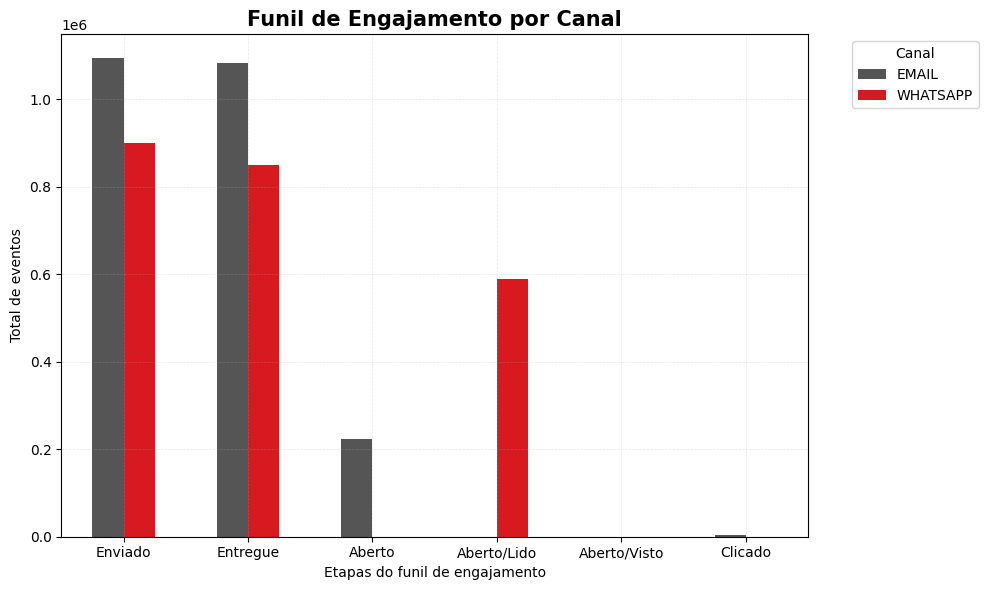

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

#Total dos eventos por etapa
funil = (
    spark.table("base_engajamento_canais")
    .groupBy("canal")
    .agg(
        F.sum("enviado").alias("Enviado"),
        F.sum("entregue").alias("Entregue"),
        F.sum("aberto").alias("Aberto"),
        F.sum("aberto_lido").alias("Aberto/Lido"),
        F.sum("aberto_visto").alias("Aberto/Visto"),
        F.sum("clicado").alias("Clicado")
    )
    .toPandas()
    .set_index("canal")
    .T
)

#Cores especiais
cores = {
    "WHATSAPP": "#D71920",  
    "EMAIL": "#555555"      
}

#Gráfico sem rótulos
ax = funil.plot(kind="bar", figsize=(10,6), color=[cores.get(c, "#999999") for c in funil.columns])

plt.title("Funil de Engajamento por Canal", fontsize=15, fontweight='bold')
plt.ylabel("Total de eventos")
plt.xlabel("Etapas do funil de engajamento")
plt.xticks(rotation=0)
plt.grid(alpha=0.3, linestyle="--", linewidth=0.5)
plt.legend(title="Canal", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


Segunda questão do case

In [0]:
from pyspark.sql import functions as F

#Carregamento da base criada anteriormente
base = spark.table("base_engajamento_canais")

#Métricas principais 
analise_funil = (
    base.groupBy("canal", "nome_campanha", "frente", "categoria")
    .agg(
        F.sum("enviado").alias("total_enviado"),
        F.sum("entregue").alias("total_entregue"),
        F.sum("aberto").alias("total_aberto"),
        F.sum("aberto_lido").alias("total_aberto_lido"),
        F.sum("aberto_visto").alias("total_aberto_visto"),
        F.sum("clicado").alias("total_clicado"),
        F.sum("falhou").alias("total_falhou"),
        F.sum("custo_total").alias("custo_total")
    )
    .withColumn("taxa_entrega", F.when(F.col("total_enviado") > 0, F.col("total_entregue") / F.col("total_enviado")).otherwise(0))
    .withColumn("taxa_abertura", F.when(F.col("total_entregue") > 0, F.col("total_aberto") / F.col("total_entregue")).otherwise(0))
    .withColumn("taxa_leitura", F.when(F.col("total_entregue") > 0, F.col("total_aberto_lido") / F.col("total_entregue")).otherwise(0))
    .withColumn("taxa_visualizacao", F.when(F.col("total_entregue") > 0, F.col("total_aberto_visto") / F.col("total_entregue")).otherwise(0))
    .withColumn("taxa_clique", F.when(F.col("total_entregue") > 0, F.col("total_clicado") / F.col("total_entregue")).otherwise(0))
    .withColumn("custo_por_envio", F.when(F.col("total_enviado") > 0, F.col("custo_total") / F.col("total_enviado")).otherwise(0))
)

#Cria coluna de canal para visualizações
analise_funil = analise_funil.withColumn(
    "canal_legivel",
    F.when(F.col("canal") == "WHATSAPP", "WhatsApp Business")
     .when(F.col("canal") == "EMAIL", "E-mail Marketing")
     .otherwise(F.col("canal"))
)

#Cria visualização resumida
display(
    analise_funil.select(
        "canal_legivel", "nome_campanha", "frente", "categoria",
        "total_enviado", "total_entregue", "total_aberto",
        "total_aberto_lido", "total_aberto_visto", "total_clicado",
        "taxa_entrega", "taxa_abertura", "taxa_leitura", "taxa_visualizacao", "taxa_clique",
        "custo_total", "custo_por_envio"
    ).orderBy(F.col("custo_total").desc())
)


canal_legivel,nome_campanha,frente,categoria,total_enviado,total_entregue,total_aberto,total_aberto_lido,total_aberto_visto,total_clicado,taxa_entrega,taxa_abertura,taxa_leitura,taxa_visualizacao,taxa_clique,custo_total,custo_por_envio
WhatsApp Business,CRM_REST_RE0802_20240923_LANCAMENTO TELA DESEMPENHO_PI_CI_CLGER,CENTRAL_DE_CRESCIMENTO,CAMPANHA_INTELIGENTE,114803,115299,0,99974,0,0,1.004320444587685,0.0,0.867084710188293,0.0,0.0,28700.75,0.25
WhatsApp Business,CRM_REST_RE0803_20241002_CAPTACAO_NOVOS_WPP_PI_CLUB_CLLDS,CENTRAL_DE_CRESCIMENTO,CLUBE_IFOOD,53739,48780,0,29936,0,0,0.9077206498074024,0.0,0.6136941369413694,0.0,0.0,13434.75,0.25
WhatsApp Business,CRM_REST_RE0802_20240930_CAPTACAO-SETEMBRO-V3_WPP_PI_CI_CLNOV,CENTRAL_DE_CRESCIMENTO,CAMPANHA_INTELIGENTE,42296,38878,0,23571,0,0,0.9191885757518441,0.0,0.6062811873038737,0.0,0.0,10574.0,0.25
WhatsApp Business,CRM_REST_RE0802_20241016_CAPTACAO-OUTUBRO-161024_WPP_PI_CI_CLNOV,CENTRAL_DE_CRESCIMENTO,CAMPANHA_INTELIGENTE,41452,37699,0,21673,0,0,0.9094615458843964,0.0,0.5748958858325155,0.0,0.0,10363.0,0.25
WhatsApp Business,CRM_REST_RE0802_WPP_TESTE-OPTIN-LEADS-2024820_PI_CI_PONTUAL,CENTRAL_DE_CRESCIMENTO,CAMPANHA_INTELIGENTE,37260,35396,0,24039,0,0,0.9499731615673644,0.0,0.6791445361057746,0.0,0.0,9315.0,0.25
WhatsApp Business,CRM_REST_RE0803_20241018_ROLLOUT-CUPOM-FLEXIVEL-V2_WPP_PI_E-GRATIS_CLATI,CENTRAL_DE_CRESCIMENTO,ENTREGA_GRATIS,34231,31625,0,20002,0,0,0.9238701761561158,0.0,0.6324743083003953,0.0,0.0,8557.75,0.25
WhatsApp Business,CRM_REST_RE0801_WPP_NOVOS-AGOSTO-202487_PI_DESC-IT_PONTUAL,CENTRAL_DE_CRESCIMENTO,DESCONTO_EM_ITEM,33930,32037,0,20356,0,0,0.9442086648983201,0.0,0.6353903299310173,0.0,0.0,8482.5,0.25
WhatsApp Business,CRM_REST_RE0803_20241023_CUPOM-12-V2_WPP_PI_CLUB_CLATI,CENTRAL_DE_CRESCIMENTO,CLUBE_IFOOD,33854,31452,0,19990,0,0,0.9290482660837714,0.0,0.6355716647589978,0.0,0.0,8463.5,0.25
WhatsApp Business,CRM_REST_RE0803_20241028_CAPTACAO-OUTUBRO-2810_WPP_PI_CLUB_CLGER,CENTRAL_DE_CRESCIMENTO,CLUBE_IFOOD,29380,27321,0,17114,0,0,0.9299183117767189,0.0,0.6264045971962959,0.0,0.0,7345.0,0.25
WhatsApp Business,CRM_REST_RE0802_20240913_TESTE-QUARENTENA-ENGAJADOS-B-SEM-EXCLUSAO_WPP_PI_CI_CLNOV,CENTRAL_DE_CRESCIMENTO,CAMPANHA_INTELIGENTE,25617,23757,0,15923,0,0,0.9273919662723973,0.0,0.6702445594982531,0.0,0.0,6404.25,0.25


Bonus - Vuzualização em grafico da etapa anterior

In [0]:
%sql
SELECT
    nome_campanha,
    canal,
    SUM(enviado) AS total_enviado,
    SUM(entregue) AS total_entregue,
    SUM(aberto) AS total_aberto,
    SUM(clicado) AS total_clicado,
    SUM(custo_total) AS custo_total,
    ROUND(SUM(entregue) / NULLIF(SUM(enviado), 0), 3) AS taxa_entrega,
    ROUND(SUM(aberto) / NULLIF(SUM(entregue), 0), 3) AS taxa_abertura,
    ROUND(SUM(clicado) / NULLIF(SUM(entregue), 0), 3) AS taxa_clique
FROM base_engajamento_canais
GROUP BY nome_campanha, canal
ORDER BY total_enviado DESC;


nome_campanha,canal,total_enviado,total_entregue,total_aberto,total_clicado,custo_total,taxa_entrega,taxa_abertura,taxa_clique
CRM_REST_RE0802_20240923_LANCAMENTO TELA DESEMPENHO_PI_CI_CLGER,WHATSAPP,114803,115299,0,0,28700.75,1.004,0.0,0.0
CRM_REST_RE0802_EMAIL_INVENTARIO-AGOSTO-2024813_PI_CI_PONTUAL,EMAIL,85289,85029,21625,346,59.70229999998115,0.997,0.254,0.004
CRM_REST_RE0802_EMAIL_CAPTACAO-NOVOS-2607-2024726_PI_CI_PONTUAL,EMAIL,74830,74420,10430,97,52.38099999999821,0.995,0.14,0.001
CRM_REST_RE0803_20241002_CAPTACAO_NOVOS_EMAIL_PI_CLUB_CLLDS,EMAIL,68172,67358,13343,165,47.720400000005476,0.988,0.198,0.002
CRM_REST_RE0803_20241002_CAPTACAO_NOVOS_WPP_PI_CLUB_CLLDS,WHATSAPP,53739,48780,0,0,13434.75,0.908,0.0,0.0
CRM_REST_RE0801_EMAIL_NOVOS-AGOSTO-202487_PI_DESC-IT_PONTUAL,EMAIL,49969,49800,8287,43,34.978300000005724,0.997,0.166,0.001
CRM_REST_RE0803_20241023_CUPOM-12_EMAIL_PI_CLUB_CLATI,EMAIL,46567,46357,9738,50,32.596900000005235,0.995,0.21,0.001
CRM_REST_RE0802_20240913_TESTE-QUARENTENA-ENGAJADOS-B-SEM-EXCLUSAO_EMAIL_PI_CI_CLNOV,EMAIL,46218,45396,11285,133,32.35260000000518,0.982,0.249,0.003
CRM_REST_RE0803_20241018_ROLLOUT-CUPOM-FLEXIVEL_EMAIL_PI_CLUB_CLATI,EMAIL,44955,44710,9720,56,31.468500000004994,0.995,0.217,0.001
CRM_REST_RE0802_20240930_CAPTACAO-SETEMBRO-V3_WPP_PI_CI_CLNOV,WHATSAPP,42296,38878,0,0,10574.0,0.919,0.0,0.0


In [0]:
%sql
CREATE OR REPLACE TEMP VIEW crm_analise_cluster AS
SELECT
    bec.SubscriberKey,
    bec.canal,
    bec.nome_campanha,
    bec.frente,
    bec.categoria,
    bec.data_evento,
    cmh.macro_cluster_crm AS ciclo_vida_parceiro,
    mi.performance_classification AS classificacao_performance,
    mi.state AS estado,
    mi.city AS cidade,
    mi.merchant_city_maturity AS maturidade_mercado,
    mi.top_restaurants AS top_restaurante,
    mi.status_saturacao AS status_saturacao,
    mi.contract_mode AS tipo_contrato,
    bec.enviado,
    bec.entregue,
    bec.aberto,
    bec.aberto_lido,
    bec.aberto_visto,
    bec.clicado,
    bec.falhou,
    bec.custo_total,
    CASE WHEN bec.enviado > 0 THEN bec.entregue / bec.enviado ELSE 0 END AS taxa_entrega,
    CASE WHEN bec.entregue > 0 THEN bec.aberto / bec.entregue ELSE 0 END AS taxa_abertura,
    CASE WHEN bec.entregue > 0 THEN bec.aberto_lido / bec.entregue ELSE 0 END AS taxa_leitura,
    CASE WHEN bec.entregue > 0 THEN bec.aberto_visto / bec.entregue ELSE 0 END AS taxa_visualizacao,
    CASE WHEN bec.entregue > 0 THEN bec.clicado / bec.entregue ELSE 0 END AS taxa_clique
FROM base_engajamento_canais bec
LEFT JOIN cluster_merchant_history cmh
    ON bec.SubscriberKey = cmh.merchant_id
LEFT JOIN merchant_info mi
    ON bec.SubscriberKey = mi.contact_key_id;


“Qual canal tem melhor taxa de conversão por cluster de merchant?”

In [0]:
%sql
SELECT
    ciclo_vida_parceiro,          
    canal,                       
    COUNT(DISTINCT SubscriberKey) AS qtd_parceiros, 
    SUM(enviado) AS total_enviado,
    SUM(entregue) AS total_entregue,
    SUM(aberto) AS total_aberto,
    SUM(clicado) AS total_clicado,
    SUM(custo_total) AS custo_total,
    
    ROUND(SUM(entregue) / NULLIF(SUM(enviado), 0), 3) AS taxa_entrega,
    ROUND(SUM(aberto)   / NULLIF(SUM(entregue), 0), 3) AS taxa_abertura,
    ROUND(SUM(clicado)  / NULLIF(SUM(entregue), 0), 3) AS taxa_clique,
    ROUND(SUM(custo_total) / NULLIF(SUM(enviado), 0), 4) AS custo_medio_envio

FROM crm_analise_cluster
WHERE ciclo_vida_parceiro IS NOT NULL
GROUP BY ciclo_vida_parceiro, canal
ORDER BY ciclo_vida_parceiro, canal;


ciclo_vida_parceiro,canal,qtd_parceiros,total_enviado,total_entregue,total_aberto,total_clicado,custo_total,taxa_entrega,taxa_abertura,taxa_clique,custo_medio_envio
ATIVO,EMAIL,128339,1173460,1157191,272253,3329,821.4219999999855,0.986,0.235,0.003,7.0E-4
ATIVO,WHATSAPP,107649,1291164,1244489,0,0,322791.0,0.964,0.0,0.0,0.25
CAPTADO,EMAIL,9098,17354,17097,4108,140,12.147799999999902,0.985,0.24,0.008,7.0E-4
CAPTADO,WHATSAPP,887,1328,1301,0,0,332.0,0.98,0.0,0.0,0.25
CHURN,EMAIL,7407,17916,17457,3960,43,12.54119999999993,0.974,0.227,0.002,7.0E-4
CHURN,WHATSAPP,6314,27407,25031,0,0,6851.75,0.913,0.0,0.0,0.25
PRE_CHURN,EMAIL,11826,15846,15456,3408,39,11.09219999999985,0.975,0.22,0.003,7.0E-4
PRE_CHURN,WHATSAPP,8804,17882,17088,0,0,4470.5,0.956,0.0,0.0,0.25
REATIVADO,EMAIL,4903,9290,9094,1892,51,6.503000000000008,0.979,0.208,0.006,7.0E-4
REATIVADO,WHATSAPP,3858,9364,8924,0,0,2341.0,0.953,0.0,0.0,0.25


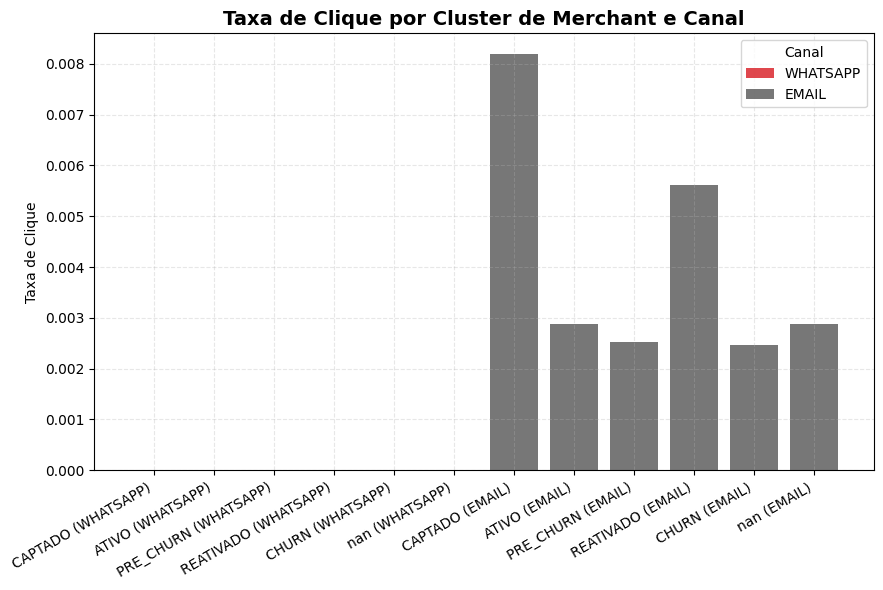

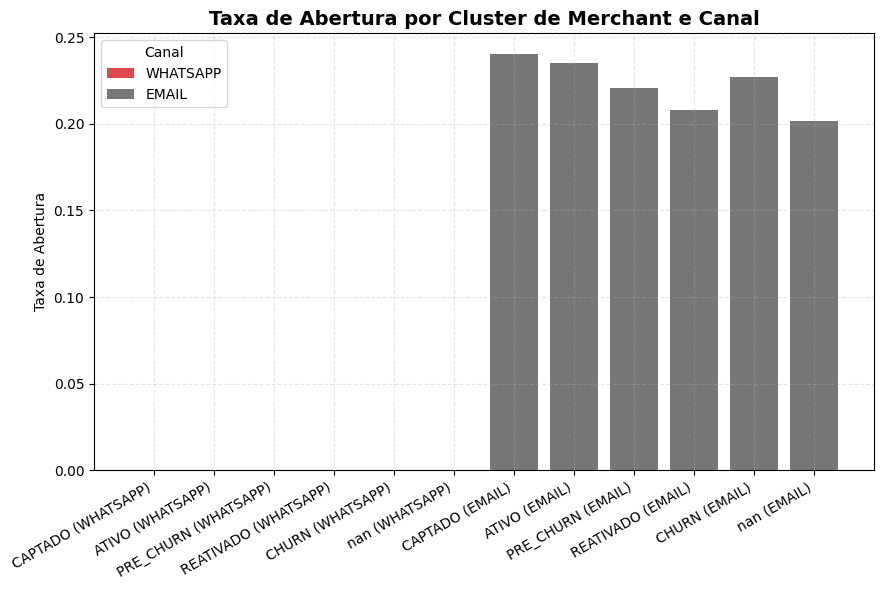

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

#Agregando dados
df = (
    spark.table("crm_analise_cluster")
    .groupBy("ciclo_vida_parceiro", "canal")
    .agg(
        F.sum("enviado").alias("enviado"),
        F.sum("entregue").alias("entregue"),
        F.sum("aberto").alias("aberto"),
        F.sum("clicado").alias("clicado"),
        F.sum("custo_total").alias("custo_total")
    )
    .withColumn("taxa_abertura", F.when(F.col("entregue") > 0, F.col("aberto") / F.col("entregue")).otherwise(0))
    .withColumn("taxa_clique", F.when(F.col("entregue") > 0, F.col("clicado") / F.col("entregue")).otherwise(0))
    .withColumn("custo_medio_envio", F.when(F.col("enviado") > 0, F.col("custo_total") / F.col("enviado")).otherwise(0))
    .toPandas()
)

#Ordena clusters
ordem_clusters = ["CAPTADO", "ATIVO", "PRE_CHURN", "REATIVADO", "CHURN"]
df["ciclo_vida_parceiro"] = pd.Categorical(df["ciclo_vida_parceiro"], categories=ordem_clusters, ordered=True)
df = df.sort_values(["ciclo_vida_parceiro", "canal"])

# Converte pra string (pra evitar o erro)
df["ciclo_vida_parceiro"] = df["ciclo_vida_parceiro"].astype(str)

#Gráfico de barras – Taxa de Clique
plt.figure(figsize=(9,6))
for canal, cor in [("WHATSAPP", "#D71920"), ("EMAIL", "#555555")]:
    subset = df[df["canal"] == canal]
    plt.bar(subset["ciclo_vida_parceiro"] + " (" + canal + ")", subset["taxa_clique"], color=cor, alpha=0.8, label=canal)

plt.title("Taxa de Clique por Cluster de Merchant e Canal", fontsize=14, fontweight="bold")
plt.ylabel("Taxa de Clique")
plt.xticks(rotation=30, ha="right")
plt.grid(alpha=0.3, linestyle="--")
plt.legend(title="Canal")
plt.tight_layout()
plt.show()

# 5️⃣ Gráfico de barras – Taxa de Abertura
plt.figure(figsize=(9,6))
for canal, cor in [("WHATSAPP", "#D71920"), ("EMAIL", "#555555")]:
    subset = df[df["canal"] == canal]
    plt.bar(subset["ciclo_vida_parceiro"] + " (" + canal + ")", subset["taxa_abertura"], color=cor, alpha=0.8, label=canal)

plt.title("Taxa de Abertura por Cluster de Merchant e Canal", fontsize=14, fontweight="bold")
plt.ylabel("Taxa de Abertura")
plt.xticks(rotation=30, ha="right")
plt.grid(alpha=0.3, linestyle="--")
plt.legend(title="Canal")
plt.tight_layout()
plt.show()


Visão somente Whats App

In [0]:
%sql
SELECT
    ciclo_vida_parceiro,
    canal,
    COUNT(DISTINCT SubscriberKey) AS qtd_parceiros,
    SUM(enviado) AS total_enviado,
    SUM(entregue) AS total_entregue,
    SUM(custo_total) AS custo_total,
    ROUND(SUM(entregue) / NULLIF(SUM(enviado), 0), 3) AS taxa_entrega,
    ROUND(SUM(custo_total) / NULLIF(SUM(enviado), 0), 4) AS custo_medio_envio
FROM crm_analise_cluster
WHERE canal = 'WHATSAPP'
  AND ciclo_vida_parceiro IS NOT NULL
GROUP BY ciclo_vida_parceiro, canal
ORDER BY total_enviado DESC;


ciclo_vida_parceiro,canal,qtd_parceiros,total_enviado,total_entregue,custo_total,taxa_entrega,custo_medio_envio
ATIVO,WHATSAPP,107649,1291164,1244489,322791.0,0.964,0.25
CHURN,WHATSAPP,6314,27407,25031,6851.75,0.913,0.25
PRE_CHURN,WHATSAPP,8804,17882,17088,4470.5,0.956,0.25
REATIVADO,WHATSAPP,3858,9364,8924,2341.0,0.953,0.25
CAPTADO,WHATSAPP,887,1328,1301,332.0,0.98,0.25


In [0]:
%sql
SELECT
    ciclo_vida_parceiro,
    canal,
    COUNT(DISTINCT SubscriberKey) AS qtd_parceiros,
    SUM(enviado) AS total_enviado,
    SUM(entregue) AS total_entregue,
    SUM(aberto) AS total_aberto,
    SUM(clicado) AS total_clicado,
    SUM(custo_total) AS custo_total,
    ROUND(SUM(entregue) / NULLIF(SUM(enviado), 0), 3) AS taxa_entrega,
    ROUND(SUM(aberto) / NULLIF(SUM(entregue), 0), 3) AS taxa_abertura,
    ROUND(SUM(clicado) / NULLIF(SUM(entregue), 0), 3) AS taxa_clique,
    ROUND(SUM(custo_total) / NULLIF(SUM(enviado), 0), 4) AS custo_medio_envio
FROM crm_analise_cluster
WHERE canal = 'EMAIL'
  AND ciclo_vida_parceiro IS NOT NULL
GROUP BY ciclo_vida_parceiro, canal
ORDER BY total_enviado DESC;


ciclo_vida_parceiro,canal,qtd_parceiros,total_enviado,total_entregue,total_aberto,total_clicado,custo_total,taxa_entrega,taxa_abertura,taxa_clique,custo_medio_envio
ATIVO,EMAIL,128339,1173460,1157191,272253,3329,821.4219999999855,0.986,0.235,0.003,7.0E-4
CHURN,EMAIL,7407,17916,17457,3960,43,12.54119999999993,0.974,0.227,0.002,7.0E-4
CAPTADO,EMAIL,9098,17354,17097,4108,140,12.147799999999902,0.985,0.24,0.008,7.0E-4
PRE_CHURN,EMAIL,11826,15846,15456,3408,39,11.09219999999985,0.975,0.22,0.003,7.0E-4
REATIVADO,EMAIL,4903,9290,9094,1892,51,6.503000000000008,0.979,0.208,0.006,7.0E-4


Terceira Questão

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW kpis_crm_b2b AS
SELECT
    canal,
    ciclo_vida_parceiro,
    frente,
    categoria,
    ROUND(AVG(taxa_entrega)*100,2) AS taxa_entrega_pct,
    ROUND(AVG(taxa_abertura)*100,2) AS taxa_abertura_pct,
    ROUND(AVG(taxa_leitura)*100,2) AS taxa_leitura_pct,
    ROUND(AVG(taxa_visualizacao)*100,2) AS taxa_visualizacao_pct,
    ROUND(AVG(taxa_clique)*100,2) AS taxa_clique_pct,
    ROUND(SUM(custo_total),2) AS custo_total,
    ROUND(SUM(custo_total)/NULLIF(SUM(enviado),0),4) AS custo_medio_envio,
    ROUND(SUM(clicado)/NULLIF(SUM(enviado),0)*100,2) AS taxa_clique_global_pct,
    ROUND(SUM(clicado)/NULLIF(SUM(entregue),0)*100,2) AS taxa_clique_sobre_entregue_pct
FROM crm_analise_cluster
GROUP BY canal, ciclo_vida_parceiro, frente, categoria;


In [0]:
%sql
SELECT
    canal,
    ciclo_vida_parceiro,
    AVG(taxa_entrega_pct) AS taxa_entrega_media,
    AVG(taxa_abertura_pct) AS taxa_abertura_media,
    AVG(taxa_clique_pct) AS taxa_clique_media,
    SUM(custo_total) AS custo_total,
    AVG(custo_medio_envio) AS custo_medio_envio
FROM kpis_crm_b2b
GROUP BY canal, ciclo_vida_parceiro
ORDER BY canal, custo_total DESC;


canal,ciclo_vida_parceiro,taxa_entrega_media,taxa_abertura_media,taxa_clique_media,custo_total,custo_medio_envio
EMAIL,ATIVO,99.046,57.355999999999995,0.23399999999999999,821.4200000000001,7.0E-4
EMAIL,null,99.28,24.734,0.458,648.85,7.0E-4
EMAIL,CHURN,98.01,19.384999999999998,0.21999999999999997,12.54,7.0E-4
EMAIL,CAPTADO,97.89500000000001,21.505000000000003,0.6025,12.149999999999999,7.0E-4
EMAIL,PRE_CHURN,98.1175,18.93,0.2225,11.1,7.0E-4
EMAIL,REATIVADO,98.42,19.6325,0.40249999999999997,6.51,7.0E-4
WHATSAPP,ATIVO,77.16999999999999,0.0,0.0,322791.0,0.25
WHATSAPP,null,66.084,0.0,0.0,179606.25,0.25
WHATSAPP,CHURN,76.78599999999999,0.0,0.0,6851.75,0.25
WHATSAPP,PRE_CHURN,81.04400000000001,0.0,0.0,4470.5,0.25


Questão 4

In [0]:
from pyspark.sql import functions as F

# Bases
base = spark.table("crm_analise_cluster")
conv = spark.table("conversion_base")

#Join
base_modelagem = (
    base.join(conv, base["SubscriberKey"] == conv["SubscriberKey"], "left")
        .withColumn("flag_converteu", F.when(conv["dt"].isNotNull(), 1).otherwise(0))
)

# Variáveis importantes
base_modelagem = base_modelagem.select(
    base["SubscriberKey"].alias("SubscriberKey"),
    base["canal"].alias("canal"),
    base["ciclo_vida_parceiro"].alias("ciclo_vida_parceiro"),
    base["frente"].alias("frente"),
    base["categoria"].alias("categoria"),
    base["enviado"].alias("enviado"),
    base["entregue"].alias("entregue"),
    base["aberto"].alias("aberto"),
    base["aberto_lido"].alias("aberto_lido"),
    base["aberto_visto"].alias("aberto_visto"),
    base["clicado"].alias("clicado"),
    base["taxa_entrega"].alias("taxa_entrega"),
    base["taxa_abertura"].alias("taxa_abertura"),
    base["taxa_leitura"].alias("taxa_leitura"),
    base["taxa_visualizacao"].alias("taxa_visualizacao"),
    base["taxa_clique"].alias("taxa_clique"),
    F.col("flag_converteu")
).fillna(0)

display(base_modelagem.limit(5))


SubscriberKey,canal,ciclo_vida_parceiro,frente,categoria,enviado,entregue,aberto,aberto_lido,aberto_visto,clicado,taxa_entrega,taxa_abertura,taxa_leitura,taxa_visualizacao,taxa_clique,flag_converteu
bb61cxZZ-f916-yde6-9fyZ-5bfde0d9008f,WHATSAPP,ATIVO,CENTRAL_DE_CRESCIMENTO,ENTREGA_GRATIS,1,1,0,1,0,0,1.0,0.0,1.0,0.0,0.0,1
9ZZy86c9-y5aa-yZey-9866-3fcabe9Z565x,WHATSAPP,PRE_CHURN,CENTRAL_DE_CRESCIMENTO,ENTREGA_GRATIS,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
16Z8160Z-x0fc-yecZ-9e3e-983xbec3c010,WHATSAPP,ATIVO,CENTRAL_DE_CRESCIMENTO,ENTREGA_GRATIS,1,1,0,1,0,0,1.0,0.0,1.0,0.0,0.0,1
1151x69Z-5db8-yx5a-bdaf-a0cf0ZZd81y3,WHATSAPP,ATIVO,CENTRAL_DE_CRESCIMENTO,ENTREGA_GRATIS,1,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0
cZ36eaay-1x8a-y03d-ac90-550fy5Za56Zb,WHATSAPP,ATIVO,CENTRAL_DE_CRESCIMENTO,ENTREGA_GRATIS,1,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0


In [0]:
%sql
DESCRIBE crm_analise_cluster;



col_name,data_type,comment
SubscriberKey,string,null
canal,string,null
nome_campanha,string,null
frente,string,null
categoria,string,null
data_evento,date,null
ciclo_vida_parceiro,string,null
classificacao_performance,string,null
estado,string,null
cidade,string,null


Treinamento do modelo de propensão

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql import functions as F

#BAse de Modelagem e Conversão
base_modelagem = (
    base.join(conv, base["SubscriberKey"] == conv["SubscriberKey"], "left")
        .withColumn("flag_converteu", F.when(conv["dt"].isNotNull(), 1).otherwise(0))
        .select(
            base["SubscriberKey"], base["canal"], base["ciclo_vida_parceiro"], base["frente"], base["categoria"],
            base["enviado"], base["entregue"], base["aberto"], base["aberto_lido"], base["aberto_visto"], base["clicado"],
            base["taxa_entrega"], base["taxa_abertura"], base["taxa_leitura"], base["taxa_visualizacao"], base["taxa_clique"],
            F.col("flag_converteu")
        ).fillna(0)
)

#variáveis categóricas
index_canal = StringIndexer(inputCol="canal", outputCol="canal_idx", handleInvalid="keep")
index_cluster = StringIndexer(inputCol="ciclo_vida_parceiro", outputCol="cluster_idx", handleInvalid="keep")

#features
features = [
    "enviado", "entregue", "aberto", "aberto_lido", "aberto_visto", "clicado",
    "taxa_entrega", "taxa_abertura", "taxa_leitura", "taxa_visualizacao", "taxa_clique",
    "canal_idx", "cluster_idx"
]
assembler = VectorAssembler(inputCols=features, outputCol="features")

#Modelo de regressão logística
lr = LogisticRegression(featuresCol="features", labelCol="flag_converteu")

#Pipeline completo
pipeline = Pipeline(stages=[index_canal, index_cluster, assembler, lr])

#Treinamento
modelo = pipeline.fit(base_modelagem)

#Predições
predicoes = modelo.transform(base_modelagem)

display(predicoes.select("SubscriberKey", "canal", "ciclo_vida_parceiro", "probability", "prediction").limit(10))


SubscriberKey,canal,ciclo_vida_parceiro,probability,prediction
bb61cxZZ-f916-yde6-9fyZ-5bfde0d9008f,WHATSAPP,ATIVO,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""1.5060169464042845E-13"",""0.9999999999998495""]}",1.0
9ZZy86c9-y5aa-yZey-9866-3fcabe9Z565x,WHATSAPP,PRE_CHURN,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.44598225180833484"",""0.5540177481916652""]}",1.0
1869y36,WHATSAPP,null,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""7.286666711906666E-14"",""0.9999999999999272""]}",1.0
16Z8160Z-x0fc-yecZ-9e3e-983xbec3c010,WHATSAPP,ATIVO,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""1.5060169464042845E-13"",""0.9999999999998495""]}",1.0
1355658,WHATSAPP,null,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.34242145132657886"",""0.6575785486734211""]}",1.0
Z3yy511,WHATSAPP,null,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.34242145132657886"",""0.6575785486734211""]}",1.0
1151x69Z-5db8-yx5a-bdaf-a0cf0ZZd81y3,WHATSAPP,ATIVO,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.5730225269331457"",""0.4269774730668543""]}",0.0
xexebf8y-3895-y98a-bd6c-y6xfZ91909a9,WHATSAPP,ATIVO,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.5730225269331457"",""0.4269774730668543""]}",0.0
cZ36eaay-1x8a-y03d-ac90-550fy5Za56Zb,WHATSAPP,ATIVO,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.5730225269331457"",""0.4269774730668543""]}",0.0
Zxy335,WHATSAPP,null,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.34242145132657886"",""0.6575785486734211""]}",1.0


Interpretação dos dados

In [0]:
base = spark.table("crm_analise_cluster")
conv = spark.table("conversion_base")


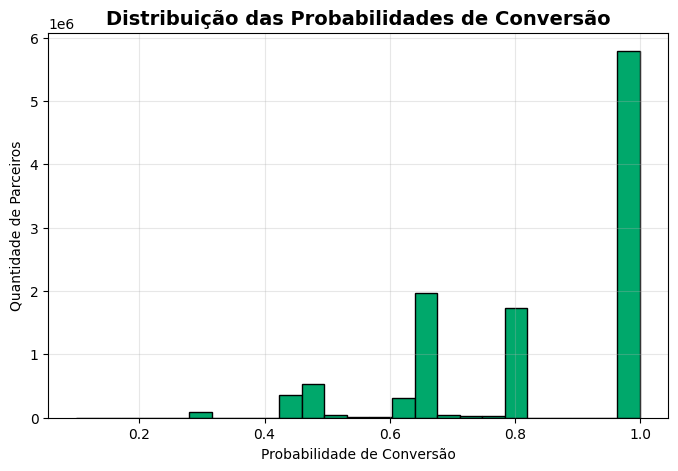

SubscriberKey,canal,ciclo_vida_parceiro,prob_convert
e1afZ980-dadd-y09f-8bb1-d09136b68ccb,WHATSAPP,ATIVO,1.0
8e5y383b-9Z39-y668-8Zb8-6abZ8aca98bd,EMAIL,ATIVO,1.0
e0b0e616-aay3-yyf5-by16-ex3edffZ6xa3,WHATSAPP,ATIVO,1.0
yZx3yxZ9-9aZ1-y09b-8e6b-Zbb5Zff351b3,EMAIL,ATIVO,1.0
1dce3dc0-0a6y-y965-860c-e0a3yb19e1a3,EMAIL,ATIVO,1.0
1yd1b3ex-86xd-yb3d-9dyb-axc15eef6d58,EMAIL,ATIVO,1.0
15d0c3y0-y98y-y9ax-9b5e-3Zc9y90b13dx,EMAIL,ATIVO,1.0
8e5y383b-9Z39-y668-8Zb8-6abZ8aca98bd,EMAIL,ATIVO,1.0
c5fa8x9c-aa55-yxx9-9cff-5x1dx1faZ5fy,EMAIL,ATIVO,1.0
fe5da1bd-965Z-y8ex-8016-86Zff0Zcxb99,EMAIL,ATIVO,1.0


In [0]:
from pyspark.sql import functions as F
from pyspark.ml.functions import vector_to_array
import matplotlib.pyplot as plt

#Extrai a probabilidade de conversão (segundo valor do vetor probability)
predicoes_prob = (
    predicoes.withColumn("prob_array", vector_to_array("probability"))
             .withColumn("prob_convert", F.col("prob_array")[1])
             .select("SubscriberKey", "canal", "ciclo_vida_parceiro", "prob_convert")
)

#Converte para Pandas (importante para o gráfico)
pdf = predicoes_prob.toPandas()

#Gera o histograma de distribuição das probabilidades
plt.figure(figsize=(8,5))
plt.hist(pdf["prob_convert"], bins=25, color="#00A86B", edgecolor="black")
plt.title("Distribuição das Probabilidades de Conversão", fontsize=14, fontweight='bold')
plt.xlabel("Probabilidade de Conversão")
plt.ylabel("Quantidade de Parceiros")
plt.grid(alpha=0.3)
plt.show()

#Mostra os 20 merchants com maior probabilidade de conversão
top_20 = (
    predicoes_prob
        .orderBy(F.desc("prob_convert"))
        .limit(20)
)

display(top_20)
